In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
%matplotlib inline
sns.set_style('darkgrid')

In [6]:
data = pd.read_csv(
    "data/processed/MSFT_3mo_processed.csv", parse_dates=["Date"], index_col="Date"
)
data.head()
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51 entries, 2024-07-29 00:00:00-04:00 to 2024-10-08 00:00:00-04:00
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          51 non-null     float64
 1   High          51 non-null     float64
 2   Low           51 non-null     float64
 3   Close         51 non-null     float64
 4   Volume        51 non-null     int64  
 5   Dividends     51 non-null     float64
 6   Stock Splits  51 non-null     float64
 7   SMA_5         51 non-null     float64
 8   RSI           51 non-null     float64
dtypes: float64(8), int64(1)
memory usage: 4.0 KB


Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
SMA_5           0
RSI             0
dtype: int64

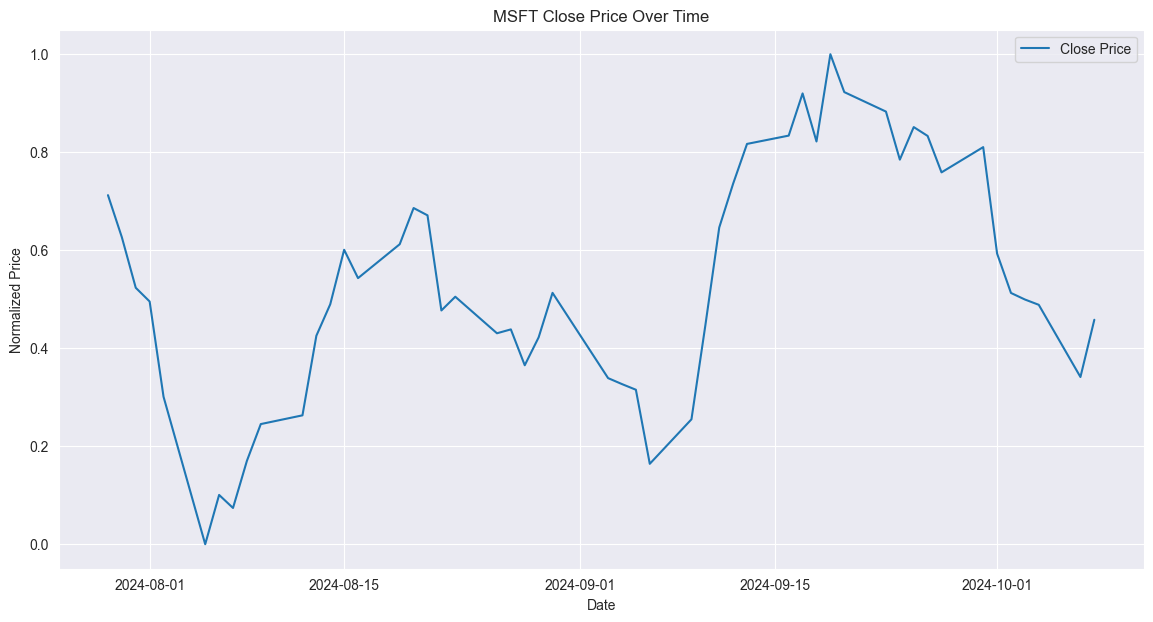

In [7]:
plt.figure(figsize=(14, 7))
plt.plot(data["Close"], label="Close Price")
plt.title("MSFT Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend()
plt.show()

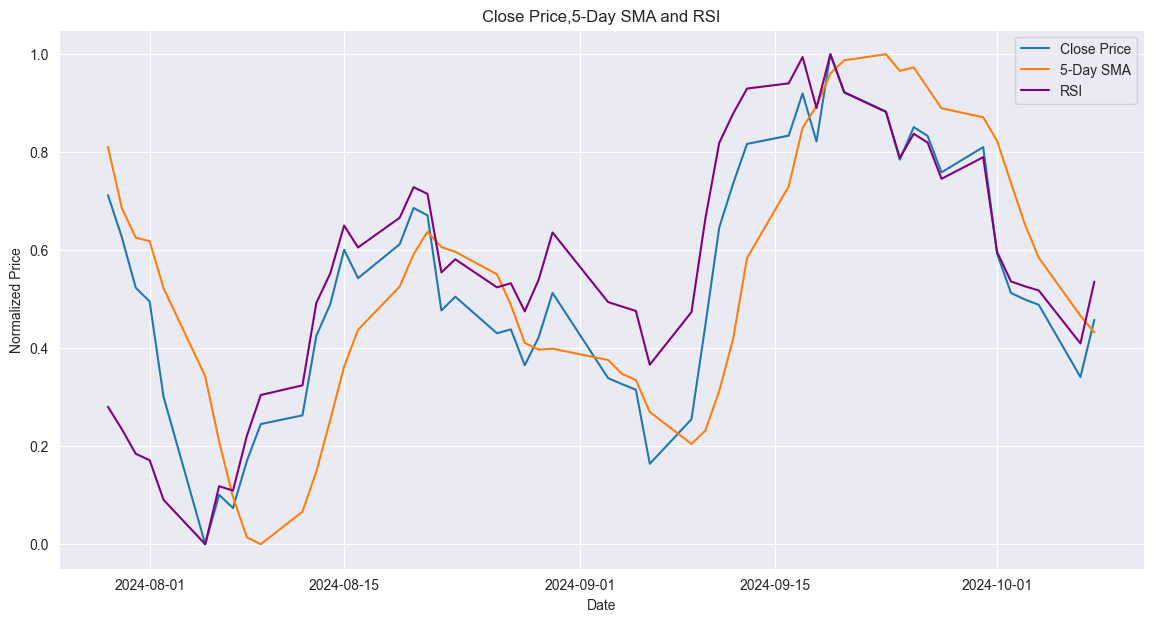

In [19]:
# Plot SMA
plt.figure(figsize=(14, 7))

plt.plot(data["Close"], label="Close Price")
plt.plot(data["SMA_5"], label="5-Day SMA")
plt.plot(data["RSI"], label="RSI", color="purple")

plt.title("Close Price,5-Day SMA and RSI")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend()
plt.show()

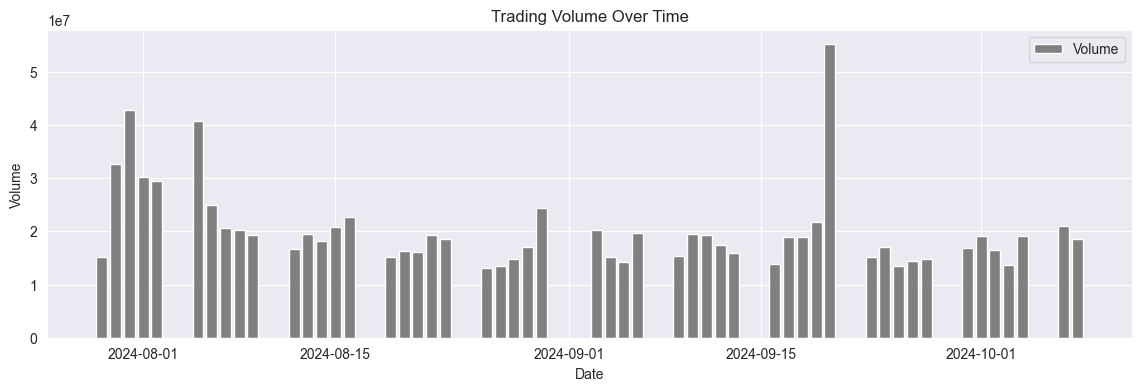

In [10]:
plt.figure(figsize=(14, 4))
plt.bar(data.index, data["Volume"], label="Volume", color="gray")
plt.title("Trading Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.show()

In [11]:
data["Returns"] = data["Close"].pct_change()

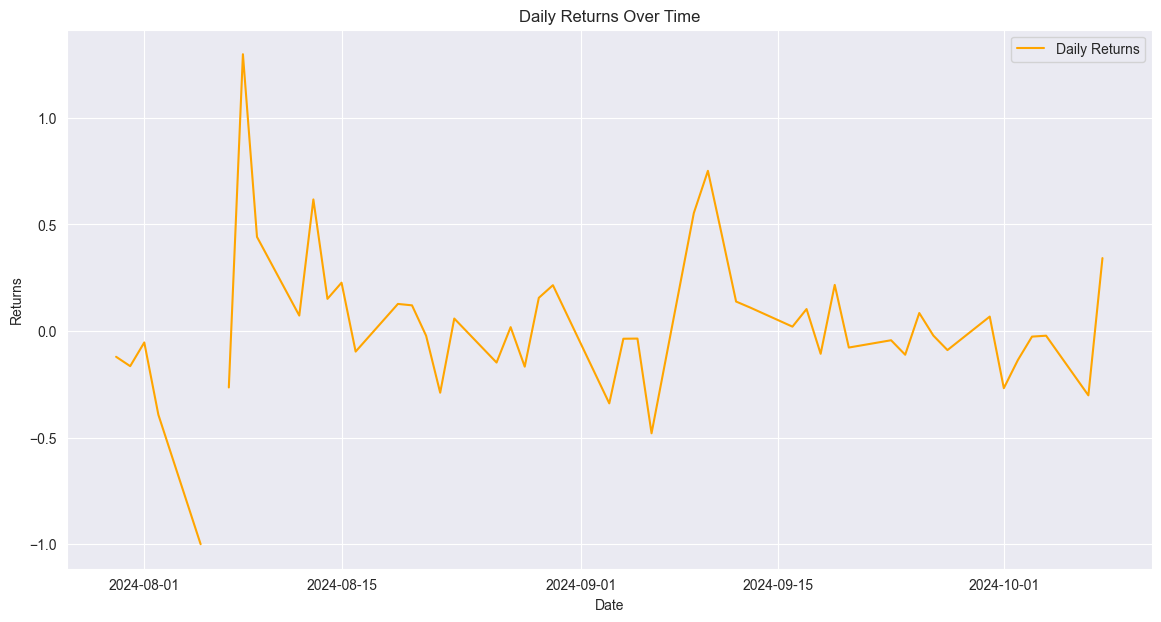

In [12]:
plt.figure(figsize=(14, 7))
plt.plot(data["Returns"], label="Daily Returns", color="orange")
plt.title("Daily Returns Over Time")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend()
plt.show()

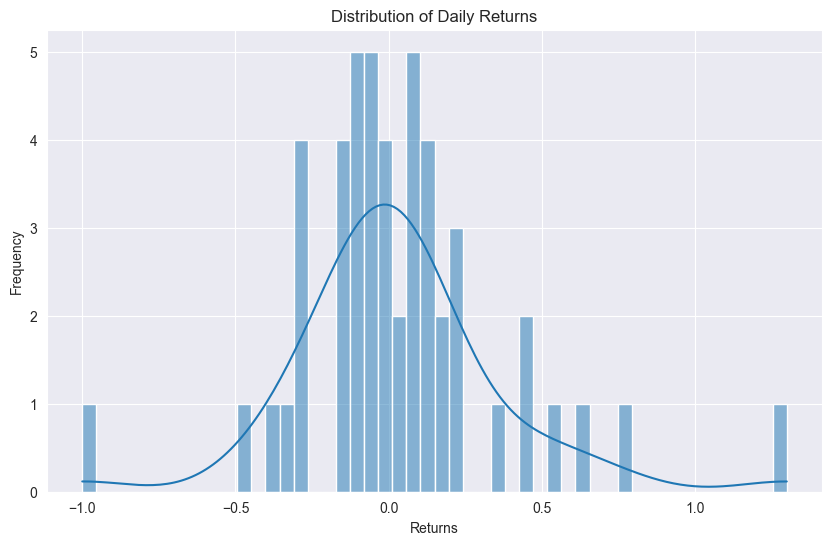

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(data["Returns"].dropna(), bins=50, kde=True)
plt.title("Distribution of Daily Returns")
plt.xlabel("Returns")
plt.ylabel("Frequency")
plt.show()

In [15]:
correlation_matrix = data.corr()
print(correlation_matrix)

                  Open      High       Low     Close    Volume  Dividends  \
Open          1.000000  0.978102  0.964856  0.931209 -0.060579   0.009737   
High          0.978102  1.000000  0.962747  0.957543 -0.022175  -0.010788   
Low           0.964856  0.962747  1.000000  0.975760 -0.116333   0.040897   
Close         0.931209  0.957543  0.975760  1.000000 -0.082691   0.041614   
Volume       -0.060579 -0.022175 -0.116333 -0.082691  1.000000   0.010820   
Dividends     0.009737 -0.010788  0.040897  0.041614  0.010820   1.000000   
Stock Splits       NaN       NaN       NaN       NaN       NaN        NaN   
SMA_5         0.881297  0.878414  0.852293  0.826678  0.046993  -0.088772   
RSI           0.732547  0.766033  0.823665  0.845883 -0.306189   0.049579   
Returns      -0.088316 -0.065476  0.044123  0.089213 -0.270350   0.083047   

              Stock Splits     SMA_5       RSI   Returns  
Open                   NaN  0.881297  0.732547 -0.088316  
High                   NaN  0.8784

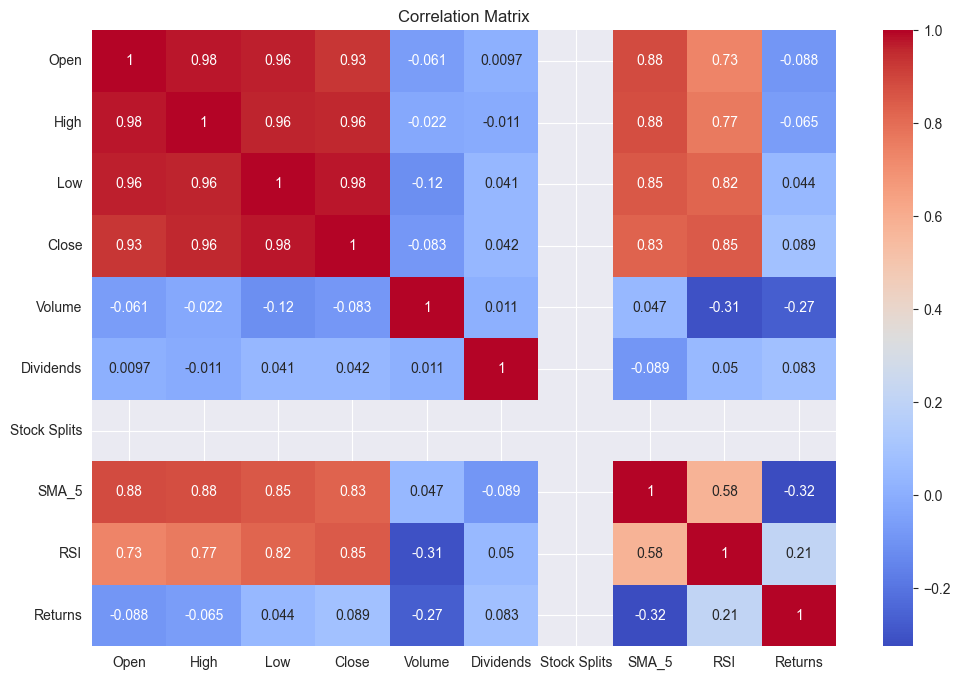

In [16]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()